## Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import spacy
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

## Exploratory Data Analysis

Let's load the data and look at few entries.

In [3]:
df = pd.read_csv("listings.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [3]:
# drop the column 'Unnamed: 0'
del df["Unnamed: 0"]

In [4]:
print("The shape of our dataframe is : {}".format(df.shape))

The shape of our dataframe is : (2253, 15)


What are the types of different features present in the dataset?

In [5]:
df.dtypes

Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
Easy Apply            object
dtype: object

Except 'Rating' and 'Founded' all other features are defined as 'object' type. Let's find out how many features have null values.

In [6]:
df.isnull().sum()

Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         1
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
Easy Apply           0
dtype: int64

Only the column 'Company Name' has one missing value. But when we look at the data closely, we find that there are some entries like '-1',-1, 'Unknown' in the dataframe. These values are equivalent to NaNs. An easy way to find this out is to look at the unique elements in each column. 

In [7]:
# number of unique elements in each column
df.nunique()

Job Title            1272
Salary Estimate        90
Job Description      2253
Rating                 37
Company Name         1513
Location              253
Headquarters          483
Size                    9
Founded               161
Type of ownership      15
Industry               89
Sector                 25
Revenue                14
Competitors           291
Easy Apply              2
dtype: int64

Let's look at unique values in some of these columns.

In [8]:
df['Rating'].unique()

array([ 3.2,  3.8,  3.4,  4.1,  3.9,  4.4,  3.7,  4. , -1. ,  3. ,  3.6,
        4.9,  3.3,  3.5,  5. ,  4.8,  4.7,  4.6,  2.9,  1. ,  3.1,  4.5,
        2.3,  4.2,  2.8,  4.3,  2.7,  2.5,  2.6,  2.4,  2. ,  2.1,  1.7,
        2.2,  1.8,  1.6,  1.9])

In [9]:
df['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', 'Unknown', '-1'], dtype=object)

So, we replace all these above mentioned entries by NaNs.

In [10]:
df.replace([-1.,-1, '-1', 'Unknown', 'Unknown / Non-Applicable'], np.nan, inplace=True)

In [11]:
# check our dataframe after the replacement
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),NaN,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),NaN,NaN
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,GoDaddy,NaN
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),NaN,NaN
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


After this replacement, we check again the number of null values in each of the features.

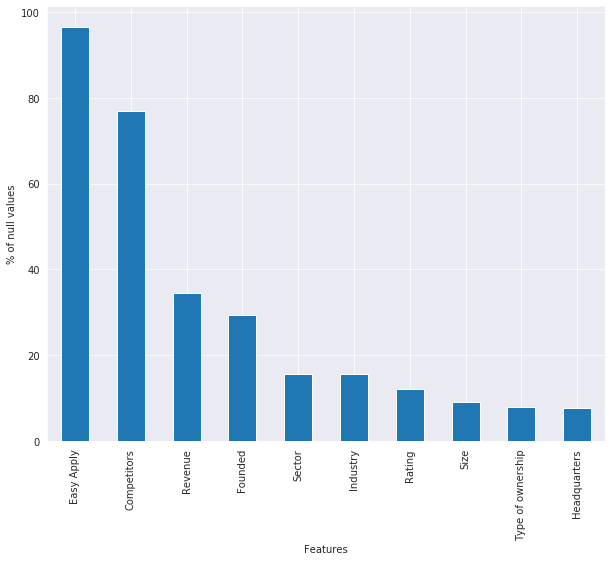

In [12]:
# calculate % of null value in each column and sort them in descending order
null_percentage = df.isnull().sum().sort_values(ascending=False)/len(df)*100

# make a plot
null_percentage[null_percentage>0.1].plot(kind='bar', figsize=(10,8))
plt.xlabel("Features")
plt.ylabel("% of null values");

As we can see from the above plot, most of the entries in 'Easy Apply' and 'Competitors' are missing. Therefore, we will drop these two columns. 

In [13]:
df.drop(['Easy Apply', 'Competitors'], axis=1, inplace=True)
print("The shape of the dataframe after dropping features : {}".format(df.shape))

The shape of the dataframe after dropping features : (2253, 13)


Let's now calculate null value percentage in each row of the dataframe.

In [14]:
# calculate % of null value in each row and sort them in descending order
row_null_percentage = df.isnull().sum(axis=1).sort_values(ascending=False)/len(df)*100
row_null_percentage

1860    0.399467
1168    0.355082
1459    0.355082
1940    0.355082
253     0.355082
          ...   
1284    0.000000
1288    0.000000
1289    0.000000
1291    0.000000
0       0.000000
Length: 2253, dtype: float64

None of the row has significant amount of null values and therefore no row can be dropped on the basis of null value percentage. 

The first question that one can ask is that **which industries are hiring data analysts actively at present?** 

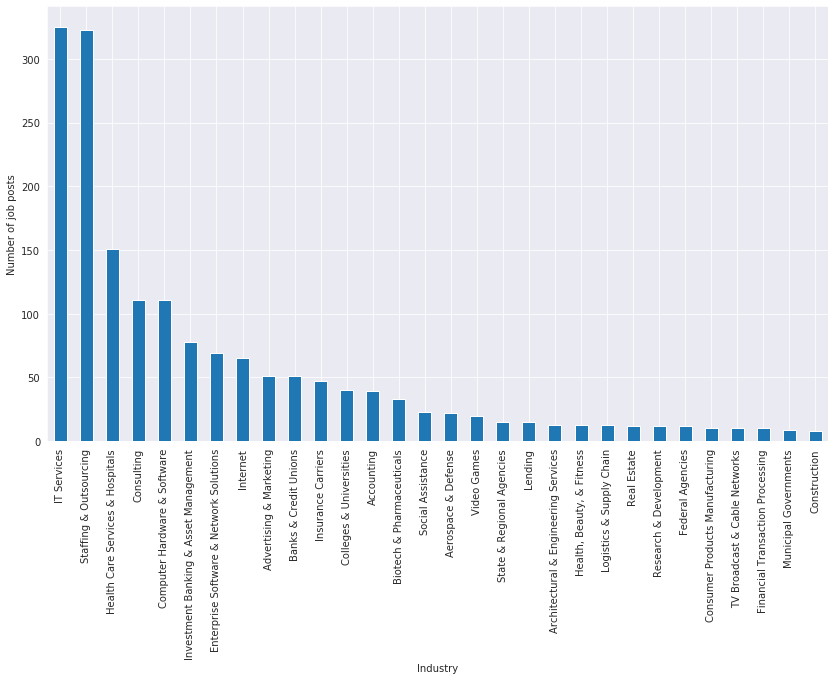

In [15]:
# top 30 industries hiring data analysts
df['Industry'].value_counts()[:30].plot(kind='bar', figsize=(14,8))
plt.xlabel("Industry")
plt.ylabel("Number of job posts");

Most of the data analyst job posts are in the IT and Staffing & Outsourcing sectors. Current data analyst post vacancy in the Health Care sector is almost half of these two.

The next interesting question could be **What is the distribution of salary across all the industries?** Let's look at the column 'Salary Estimate'.

In [16]:
# first 10 entries in 'Salary Estimate'
df['Salary Estimate'][:10]

0    $37K-$66K (Glassdoor est.)
1    $37K-$66K (Glassdoor est.)
2    $37K-$66K (Glassdoor est.)
3    $37K-$66K (Glassdoor est.)
4    $37K-$66K (Glassdoor est.)
5    $37K-$66K (Glassdoor est.)
6    $37K-$66K (Glassdoor est.)
7    $37K-$66K (Glassdoor est.)
8    $37K-$66K (Glassdoor est.)
9    $37K-$66K (Glassdoor est.)
Name: Salary Estimate, dtype: object

We need to clean this. We create three new features from this column - minimum, maximum and average salaries offered in different industries and then drop the original feature.

In [17]:
# the minimum salary offered
df['min_salary'] = df['Salary Estimate'].apply(lambda x:float(x.split()[0].split("-")[0].strip("$,K")) 
                                                          if not pd.isnull(x) else x)

# the maximum salary offered
df['max_salary'] = df['Salary Estimate'].apply(lambda x:float(x.split()[0].split("-")[1].strip("$,K")) 
                                                          if not pd.isnull(x) else x)

# the average salary offered
df['avg_salary'] = (df['min_salary'] + df['max_salary'])/2.

# drop the original column
df.drop('Salary Estimate', axis=1, inplace=True)

Now we can look at the distribution of average salary in different industries.

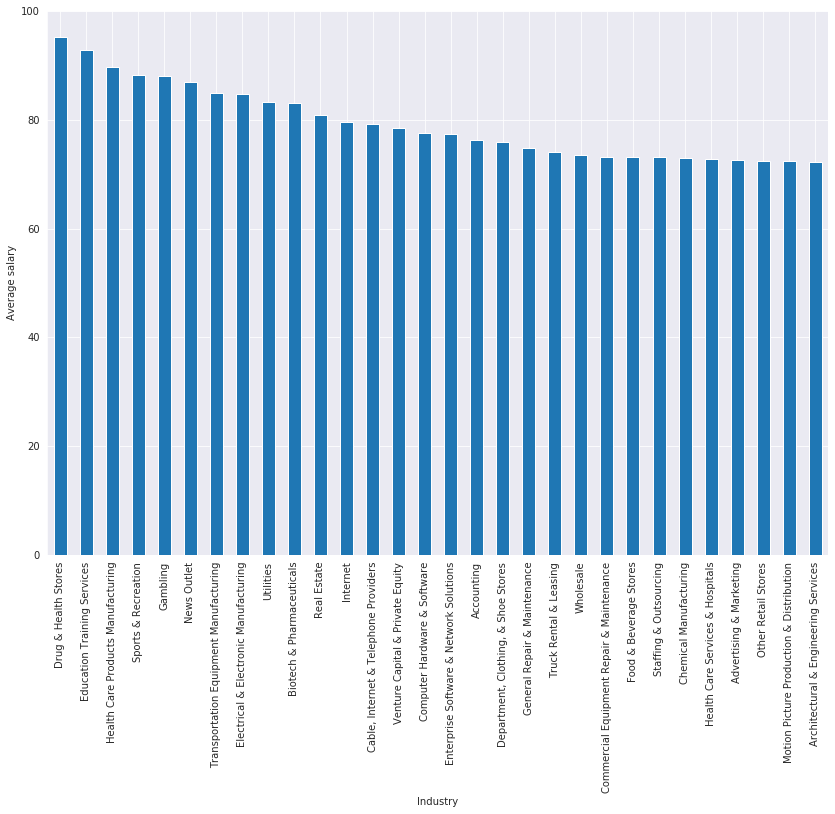

In [18]:
# plot top 30 industries with highest offered salaries
df.groupby('Industry')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Industry')
plt.ylabel('Average salary');

This is interesting! Although IT sector has maximum number of job postings, the salary offered does not fall into top 30. The healthcare industry ('Drug & Health Stores', 'Health Care Products Manufacturing', 'Biotech & Pharmaceuticals', 'Health Care Services & Hospitals') generally has a high average salary. The average salary offered in education industry is almost comparable to that of healthcare industry. This plot tells us that even if some industries have fewer job postings, they offer better salaries.

**Is there any particular location with high demand of data analysts?**

In [19]:
# the 'Location' column
df['Location']

0         New York, NY
1         New York, NY
2         New York, NY
3         New York, NY
4         New York, NY
             ...      
2248        Denver, CO
2249    Centennial, CO
2250        Denver, CO
2251    Centennial, CO
2252    Broomfield, CO
Name: Location, Length: 2253, dtype: object

Let's extract only the state names from the 'Location' column.

In [20]:
df['Job_state'] = df['Location'].apply(lambda x:x.split(",")[-1].strip())
df['Job_state']

0       NY
1       NY
2       NY
3       NY
4       NY
        ..
2248    CO
2249    CO
2250    CO
2251    CO
2252    CO
Name: Job_state, Length: 2253, dtype: object

In [21]:
# how many unique values?
df['Job_state'].nunique()

19

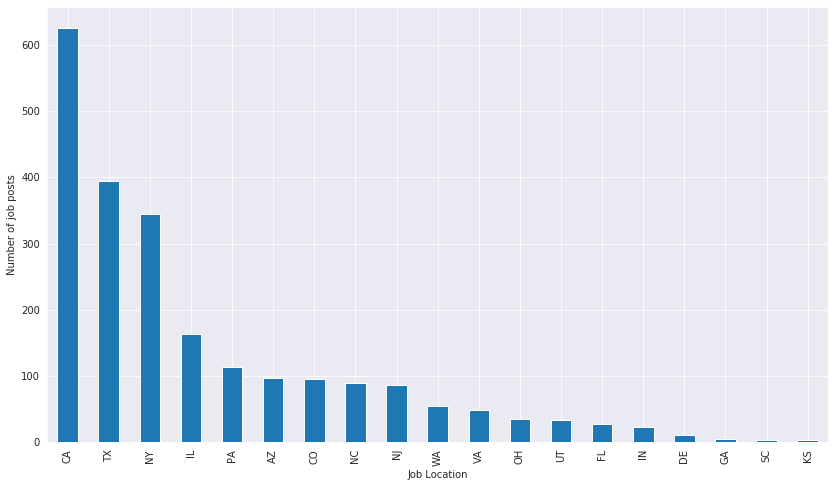

In [22]:
# plot total number of job posting in each state
df['Job_state'].value_counts().plot(kind="bar", figsize=(14,8))
plt.xlabel("Job Location")
plt.ylabel("Number of job posts");

Most of the vacancies are in CA followed by TX and NY which have almost equal number of vacancies in the data analyst post.

**Which companies are hiring data analysts actively?** Let's look at the column 'Company Name'.

In [23]:
df['Company Name'].unique()[:20]

array(['Vera Institute of Justice\n3.2',
       'Visiting Nurse Service of New York\n3.8', 'Squarespace\n3.4',
       'Celerity\n4.1', 'FanDuel\n3.9', 'Point72\n3.9', 'Two Sigma\n4.4',
       'GNY Insurance Companies\n3.7', 'DMGT\n4.0', 'Riskified\n4.4',
       'NYU Langone Health\n4.0', 'BulbHead', 'Montefiore Medical\n3.7',
       'Known\n3.0', 'Advisor Group\n3.4', 'CodeGreen Solutions\n3.6',
       'Undertone\n3.8', 'NYSTEC\n3.8',
       'Education Development Center, Inc.\n3.9',
       'Teachers Pay Teachers\n4.9'], dtype=object)

In [24]:
# extract only the company name
df['Company Name'] = df['Company Name'].apply(lambda x:x.split("\n")[0].strip() if not pd.isnull(x) else x)

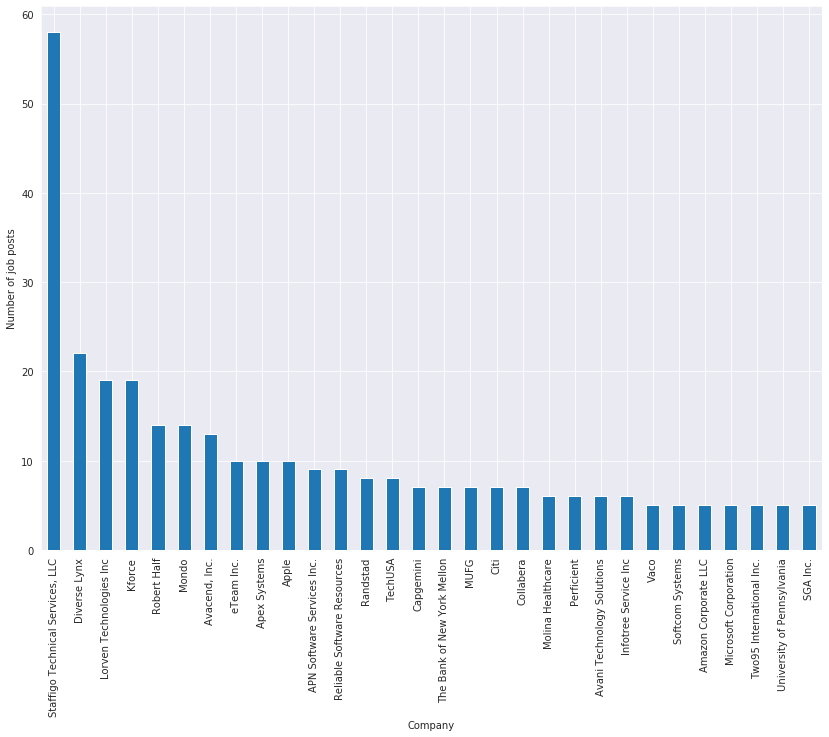

In [25]:
# plot top 30 companies with high job postings
df['Company Name'].value_counts()[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Company')
plt.ylabel('Number of job posts');

As we can see from the above plot, 'Staffigo Technical Services' has a large number of openings for data analysts.

**Which companies are offering high salaries?**

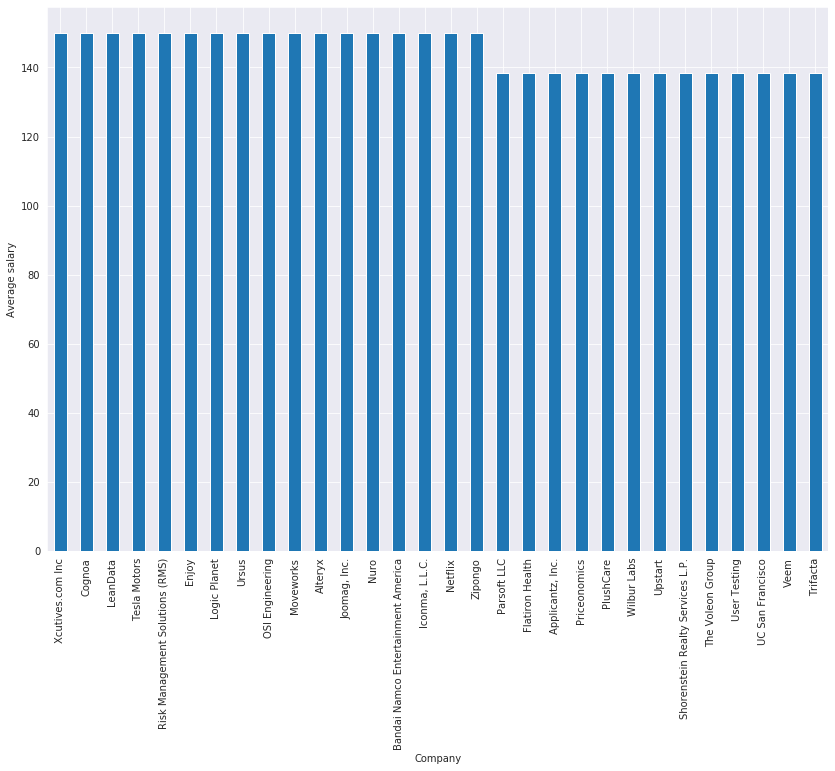

In [26]:
# plot top 30 companies with high average salaries
df.groupby('Company Name')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Company')
plt.ylabel('Average salary');

Let's study these companies closely.

In [27]:
# store top 30 companies offering high salaries in a list
top_30_comps = list(df.groupby('Company Name')['avg_salary'].mean().sort_values(ascending=False)[:30].index)

**How are the ratings of these companies?**

In [28]:
print("The rating is given on a scale {}-{}.".format(df['Rating'].min(), df['Rating'].max()))

The rating is given on a scale 1.0-5.0.


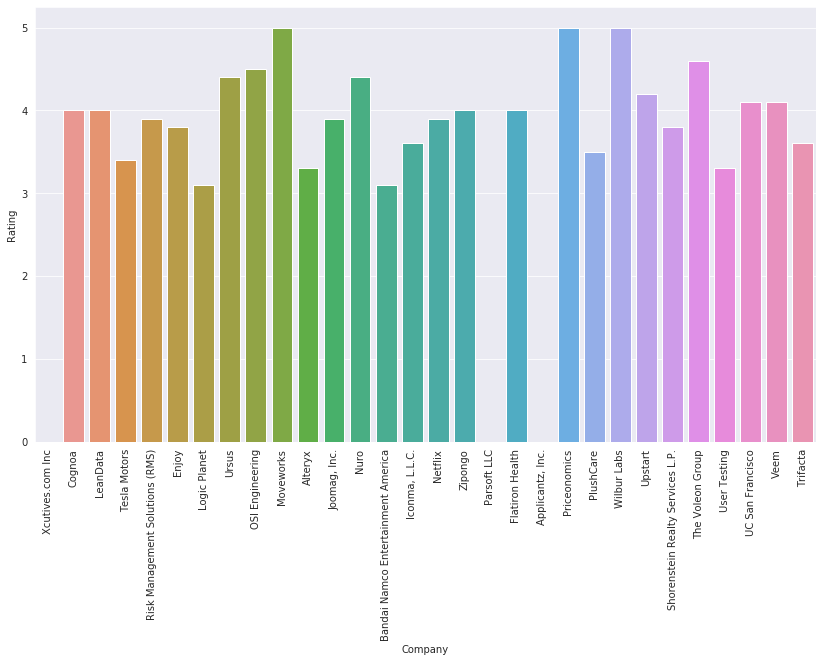

In [29]:
# plot ratings of these companies
plt.figure(figsize=(14,8))
sns.barplot(x=df[df['Company Name'].isin(top_30_comps)]['Company Name'], 
            y=df[df['Company Name'].isin(top_30_comps)]['Rating'],
            order = top_30_comps)
plt.xlabel('Company')
plt.xticks(rotation=90);

All the companies (except three) have a minimum rating value 3. 'Xcutives.com Inc', 'Applicantz, Inc' and 'Parsoft LLC' - although these three companies are offering high salaries to candidates, no rating is available for them. One reason might be that these are comparatively new companies.

**What about number of currently employed staffs in these companies?** The relevant feature for this question is 'Size'.

In [30]:
# unique values in the feature 'Size'
df['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', nan], dtype=object)

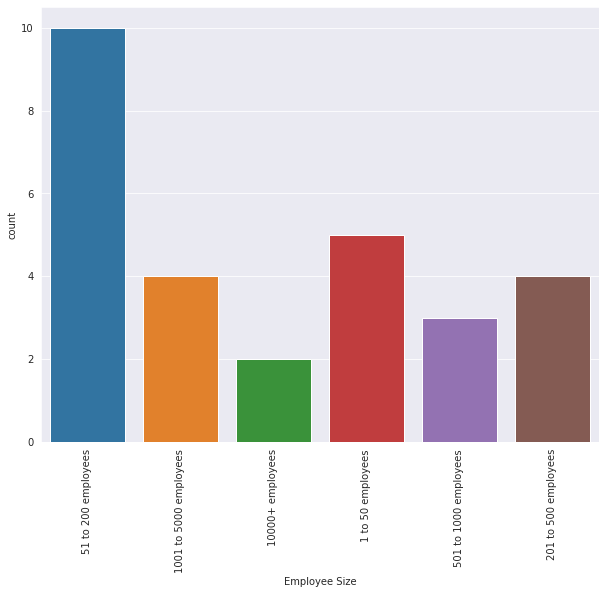

In [31]:
# Employee size of top 30 high paying companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Size'])   
plt.xlabel('Employee Size')
plt.xticks(rotation=90);

Surprisingly, most of the high paying companies are small in size. These are likely to be start-ups. So the data is telling us that start-ups are likely to pay more to data analysts as compared to big companies.

Another important question to explore could be **what are the financial status of these companies?** To find an answer to this, we look at the available feature 'Revenue'.

In [32]:
# unique values in 'Revenue'
df['Revenue'].unique()

array(['$100 to $500 million (USD)', '$2 to $5 billion (USD)', nan,
       '$50 to $100 million (USD)', '$1 to $2 billion (USD)',
       '$5 to $10 billion (USD)', '$1 to $5 million (USD)',
       '$25 to $50 million (USD)', '$10+ billion (USD)',
       'Less than $1 million (USD)', '$10 to $25 million (USD)',
       '$500 million to $1 billion (USD)', '$5 to $10 million (USD)'],
      dtype=object)

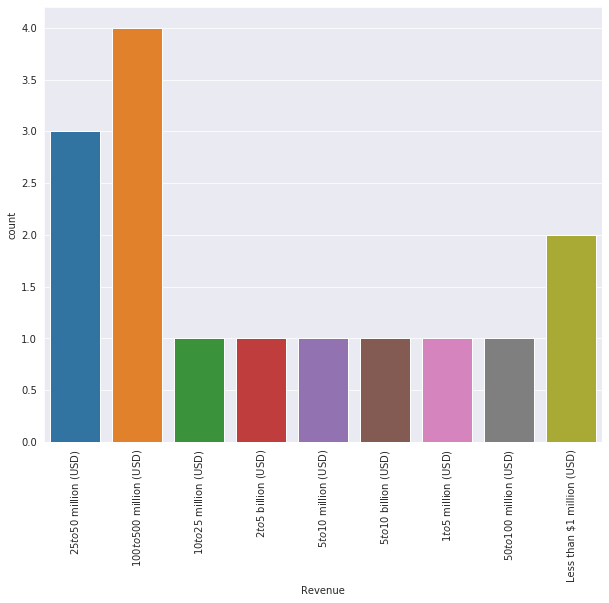

In [33]:
# plot revenues of top 30 high paying companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Revenue'])    
plt.xticks(rotation=90);

The plot reiterates the same thing - most of the data analyst job positions are available in small to medium sized companies.

One more question in this chain - **where are these companies located?**

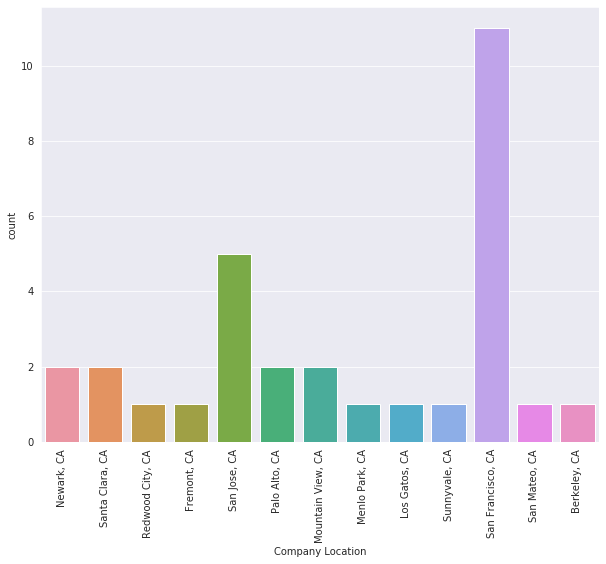

In [34]:
# plot locations of these top 30 companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Location'])    
plt.xlabel("Company Location")
plt.xticks(rotation=90);

All these companies are situated in CA (mainly in the city San Francisco)! CA not only has a large number of openings for data analysts, it also offers high salaries as compared to other states. All the information that we gathered from this exercise can be summarized as follows:

**Companies offering high salaries to data analysts are small in size with average total revenue, generally have decent ratings and are mostly situated in CA.** 

So, if you are looking for a career in data analytics, CA might be you next destination!

To get a job, one must have the required skill sets. **What skills are companies looking for in a data analyst?** The feature of interest in this case is 'Job Description'.

Let's find out average lengths of available job descriptions in the dataset.

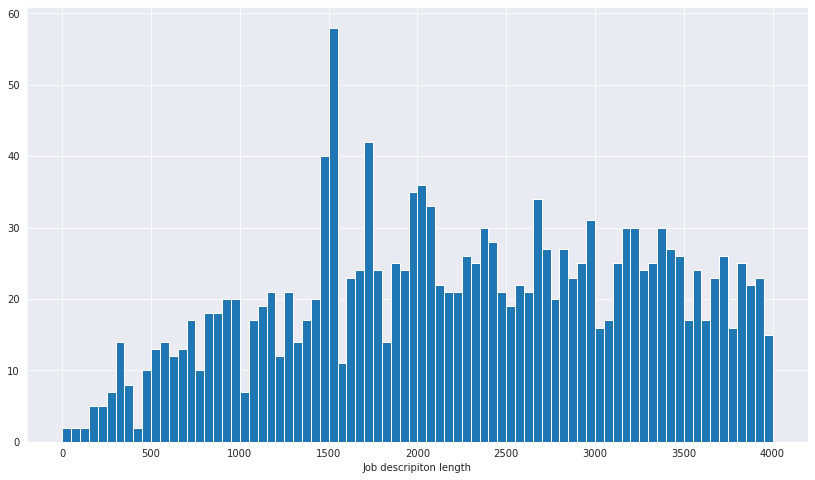

In [4]:
desc_len = [len(desc) for desc in df['Job Description']]
plt.figure(figsize=(14,8))
plt.xlabel('Job descripiton length')
plt.hist(desc_len, bins=80, range=(0,4000));

Therefore, in general, job descriptions are quite long. But our interest is in some keywords like 'C++', 'pyhton', 'sql' etc that are closely related to required skills of an applicant for the post of data analyst. We use the library 'spaCy' to extract these keywords from a huge corpus. The steps are as follows:

- We look for all the named entities in the corpus.
- A quick check shows that most of our keywords (skills) of interest are labeled as 'ORG'.

In [5]:
# load the required libraries and create an nlp object
nlp = spacy.load('en_core_web_sm')

In [6]:
# list to store extracted skill keywords
skill_list = []

# feed the entire corpus into batches of 100 samples at a time
for i in range(0,len(df), 100):
    # for the last batch
    if i+np.mod(2253,100)==len(df):
        # combine job descriptions of 100 samples into a single string
        text = " ".join(des for des in df['Job Description'][i:len(df)])
    else :
        text = " ".join(des for des in df['Job Description'][i:i+100])
        
    # process raw text with the nlp object that holds all information about the tokens, their linguistic 
    #features and relationships    
    doc = nlp(text)

    # loop over the named entities
    for entity in set(doc.ents):
        # select entities with label 'ORG'
        if entity.label_ == 'ORG':
            # add to the list
            skill_list.append(entity.text)

In [7]:
# count how many times each entity appears in the list
word_count = Counter(skill_list)
# print the top 100 named entities
word_count.most_common(100)

[('SQL', 1535),
 ('Python', 468),
 ('ETL', 417),
 ('SAS', 392),
 ('Microsoft', 287),
 ('BI', 241),
 ('Data Analyst', 179),
 ('SAP', 145),
 ('Oracle', 143),
 ('PowerPoint', 142),
 ('AWS', 139),
 ('Microsoft Office', 138),
 ('Data', 133),
 ('Business Intelligence', 105),
 ('Computer Science', 103),
 ('Analytics', 101),
 ('XML', 98),
 ('The Data Analyst', 96),
 ('Data Science', 90),
 ('Access', 88),
 ('Healthcare', 83),
 ('KPI', 81),
 ('SQL Server', 79),
 ('EEO', 77),
 ('Business Objects', 75),
 ('Word', 68),
 ('CA', 64),
 ('Data Governance', 64),
 ('MDM', 64),
 ('SSRS', 62),
 ('Data Quality', 60),
 ('Google Analytics', 60),
 ('Fortune', 59),
 ('AI', 58),
 ('Salesforce', 57),
 ('Senior Data Analyst', 56),
 ('Operations', 56),
 ('UAT', 56),
 ('Spark', 53),
 ('Data Analytics', 53),
 ('MS Office', 52),
 ('ERP', 52),
 ('SharePoint', 48),
 ('Information Technology', 48),
 ('Big Data', 47),
 ('Finance', 46),
 ('University', 46),
 ('Google', 45),
 ('Tableau', 44),
 ('Data Management', 44),
 ('Mi

We have been successful in extracting skills like SQL, Python, ETL etc from the corpus. There are also some unrelated words/phrases like healthcare, data governance etc but overall spaCy has done a good job in extracting relevant skills. The most required skill is SQL!

In [37]:
# make a list of actual skills extracted from the corpus
skill_set = ['SQL', 'Python', 'ETL', 'SAS', 'SAP', 'Oracle', 'PowerPoint', 'AWS', 'Microsoft Office',
             'XML', 'SQL Server', 'AI', 'Spark', 'MS Office', 'ERP', 'Big Data',  'Tableau', 'Hadoop', 
             'JavaScript', 'Azure']

# loop over top 100 extracted skill keywords/phrases
# select skills present in the above list
# add to a dictionary    
skill_count_dict = {skill:count for skill, count in word_count.most_common(100) if skill in skill_set}        
            
# SQL and SQL server basically point to the same thing. Let's combine them into a single key            
skill_count_dict['SQL'] = skill_count_dict['SQL'] + skill_count_dict['SQL Server']

# remove the other key
del skill_count_dict['SQL Server']

In [38]:
# create a dataframe with two columns - skills and corresponding counts
skill_count_df = pd.DataFrame(skill_count_dict.items(), columns=['Skill', 'Total Count'])
skill_count_df

,Skill,Total Count
0,SQL,1614
1,Python,468
2,ETL,417
3,SAS,392
4,SAP,145
5,Oracle,143
6,PowerPoint,142
7,AWS,139
8,Microsoft Office,138
9,XML,98


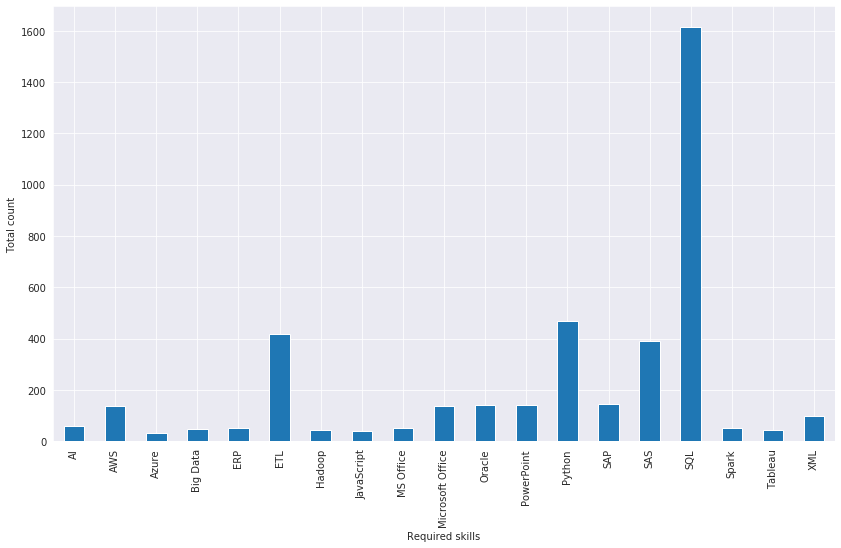

In [39]:
# plot how many times a skill appeared in the corpus
skill_count_df.groupby('Skill')['Total Count'].max().plot(kind='bar', figsize=(14,8))
plt.xlabel("Required skills")
plt.ylabel("Total count");